<a href="https://colab.research.google.com/github/dsamsonov1/to2rep/blob/main/to2rep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install packages

!pip install scikit-rf
!pip install -U kaleido
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 30.9 MB 90.9 MB/s 
  Created wheel for scikit-rf: filename=scikit_rf-0.23.0-py3-none-any.whl size=3405278 sha256=8c9a5e5e17c29927eddf09c4bd7c38c8ccee54679d65d528c8a16a8c46827779
  Stored in directory: /root/.cache/pip/wheels/24/fc/b4/65c437a72a98ebaaa5307c1d1fd9ce988d7a12a6228aa33fe2
Successfully built scikit-rf
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79.9 MB 145 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
# find intersection of S11 with VSWR=const
import numpy as np
import skrf as rf
from skrf.media.definedAEpTandZ0 import DefinedAEpTandZ0
import plotly.graph_objects as go
from google.colab import drive
import csv

def vswr_circle(swr):
  theta = np.linspace(0, 2*np.pi, 720)
  r = (swr-1)/(swr+1)
  z = (1+r*np.exp(1.0j*theta))/(1-r*np.exp(1.0j*theta))
  return z

base_path = '/content/drive/My Drive/to2rep/'

modes = {
#    '0.5Pa_50W_83.0MHz_SWR1.2_D_Ar':  (1.2, 83.0, 0, 50, 390, 600, 4, 4),# 10 sec
#    '0.5Pa_150W_82.3MHz_SWR1.4_D_Ar': (1.4, 82.3, 0, 1500, -800, 1600, 20.3, 20.1), # 1 min 51 sec
#    '0.5Pa_300W_83.2MHz_SWR1.5_D_Ar': (1.5, 83.2, 0, 200, 200, 720, 5, 5), # 53 sec
#    '3Pa_50W_81.8MHz_SWR1.2_D_Ar':    (1.2, 81.8, 0, 50, -520, -310, 1, 1), # 2 min 18 sec
#    '3Pa_150W_81.4MHz_SWR1.4_D_Ar':   (1.4, 81.4, 0, 70, -400, -150, 2, 2), # 56 sec
#    '3Pa_300W_80.6MHz_SWR1.6_D_Ar':   (1.6, 80.6, 0, 50, -200, -100, 0.5, 0.5), # 4 min 9 sec
#    '7Pa_50W_79.1MHz_SWR1.2_D_Ar':    (1.2, 79.1, 0, 4, -80, -68, 0.5, 0.5), # 2 sec
#    '7Pa_150W_79.2MHz_SWR1.2_D_Ar':   (1.2, 79.2, 0, 4, -81, -70, 0.5, 0.5), # 2 sec
#    '7Pa_300W_79.1MHz_SWR1.9_D_Ar':   (1.9, 79.1, 0, 25, -100, -55,1, 1), # 14 sec
#    '10Pa_50W_78.9MHz_SWR1.6_D_Ar':   (1.6, 78.9, 0, 21, -90, -55, 1, 1), # 9 sec
#    '10Pa_150W_79.2MHz_SWR1.2_D_Ar':  (2.7, 80.3, 0, 140, -260, -65, 1, 1), # 1 min 1 sec
#    '10Pa_300W_79.1MHz_SWR2_D_Ar':    (2.0, 79.1, 0, 30, -100, -55, 1, 1), # 17 sec
#    '0.5Pa_50W_82.9MHz_SWR_2_C_Ar':   (2.0, 82.9, 0, 600, -1000, 250, 2, 2.3), # 28 min 56 sec
#    '0.5Pa_150W_83.2MHz_SWR2.5_C_Ar': (2.5, 83.2, 0, 500, -1300, 170, 5.3, 2.1), # 11 min 20 sec
#    '3Pa_50W_78.5MHz_SWR2.3_C_Ar':    (2.3, 83.2, 0, 650, -1400, 160, 5.3, 2.1), #!!!!!
#    '3Pa_150W_80.3MHz_SWR2.7_C_Ar':   (2.7, 80.3, 0, 140, -260, -65, 1, 1), # 4 min 33 sec
#    '7Pa_50W_78.3MHz_SWR2.2_C_Ar':    (2.2, 78.3, 0, 22, -80, -45, 0.2, 0.2), # 3 min 14 sec
#    '7Pa_150W_78.2MHz_SWR2.4_C_Ar':   (2.4, 78.2, 0, 25, -80, -40, 0.2, 0.2), # 4 min 14 sec
#    '10Pa_50W_78.2MHz_SWR2_C_Ar':     (2.0, 78.2, 0, 20, -75, -45, 0.1, 0.1), # 10 min 10 sec
#    '10Pa_150W_77.8MHz_SWR2.5_C_Ar':  (2.5, 77.8, 0, 25, -70, -38, 0.2, 0.2) # 3 min 25 sec
    '0.5Pa_50W_82.3MHz_SWR2.2_C_He':    (2.2, 82.3, 0, 270, -300, 450, 2.3, 2.3)
#    '0.5Pa_150W_82.4MHz_SWR3.0_C_He':   (3.0, 82.4, 0, 150, -230, 250, 2.3, 5.1),
#    '0.5Pa_250W_80.6MHz_SWR3.0_C_He':   (3.0, 80.6, 0, 270, -450, -50, 2, 1),
#    '3Pa_50W_79.9MHz_SWR2.7_C_He':      (2.7, 79.9, 0, 90, -230, -50, 1, 1),
#    '3Pa_150W_77.9MHz_SWR2.8_C_He':    (2.8, 77.9, 0, 50, -80, -35, 0.5, 0.5),
#    '3Pa_250W_78.3MHz_SWR3.0_C_He':    (3.0, 78.3, 0, 40, -100, -35, 0.5, 0.5),
#    '7Pa_50W_78.2MHz_SWR2.3_C_He':     (2.3, 78.2, 0, 25, -80, -40, 0.5, 0.5),
#    '7Pa_150W_78.0MHz_SWR2.5_C_He':    (2.5, 78.0, 0, 25, -80, -40, 0.5, 0.5),
#    '7Pa_250W_77.8MHz_SWR2.6_C_He':    (2.6, 77.8, 0, 25, -75, -37, 0.5, 0.5),
#    '10Pa_50W_78.2MHz_SWR2.4_C_He':    (2.4, 78.2, 0, 25, -80, -40, 0.5, 0.5),
#    '10Pa_150W_77.1MHz_SWR2.4_C_He':   (2.4, 77.1, 0, 17, -60, -34, 0.5, 0.5),
#    '10Pa_250W_77.1MHz_SWR2.6_C_He':   (2.6, 77.1, 0, 20, -60, -32, 0.5, 0.5),
#    '0.5Pa_50W_84.1MHz_SWR1.2_D_He':   (1.2, 84.1, 0, 5, 145, 180, 0.5, 0.5),
#    '0.5Pa_150W_83.9MHz_SWR1.35_D_He': (1.35, 83.9, 0, 23, 150, 230, 0.5, 1),
#    '0.5Pa_300W_84.0MHz_SWR1.35_D_He': (1.35, 84.0, 0, 23, 140, 220, 0.5, 1),
#    '3Pa_50W_81.0MHz_SWR1.3_D_He': (1.3, 81.0, 0, 30, -220, -140, 0.5, 1),
#    '3Pa_150W_81.3MHz_SWR1.2_D_He':  (1.2, 81.3, 0, 25, -280, -180, 0.5, 1),
#    '3Pa_300W_81.5MHz_SWR1.25_D_He': (1.25, 81.5, 0, 40, -370, -210, 0.5, 1),
#    '7Pa_50W_79.8MHz_SWR1.5_D_He': (1.5, 79.8, 0, 20, -115, -75, 0.5, 1),
#    '7Pa_150W_80.2MHz_SWR1.25_D_He': (1.25, 80.2, 0, 10, -115, -95, 0.5, 0.5),
#    '7Pa_300W_80.7MHz_SWR1.1_D_He': (1.13, 80.7, 0, 5, -155, -135, 0.1, 0.1),
#    '10Pa_50W_79.3MHz_SWR1.6_D_He': (1.6, 79.3, 0, 20, -100, -61, 0.5, 0.5),
#    '10Pa_150W_79.9MHz_SWR1.25_D_He': (1.25, 79.9, 0, 10, -110, -85, 0.5, 0.5),
#    '10Pa_300W_80.3MHz_SWR1.1_D_He': (1.13, 80.3, 0, 10, -130, -95, 0.5, 0.5)
}


for md in modes:
  
  swr0,f0,re_min,re_max,im_min,im_max,re_res,im_res = modes[md]

  print (f'Starting mode {md}')

  re = np.arange(re_min, re_max, re_res)
  im = np.arange(im_min, im_max, im_res)

  freq = rf.Frequency.from_f([f0], 'MHz');
  line2 = DefinedAEpTandZ0(frequency=freq, A=0.09, f_A=80e6, ep_r=1.5, Z0=52.9)
  line1 = DefinedAEpTandZ0(frequency=freq, A=0.41, f_A=80e6, ep_r=8.3, Z0=29.4)
  line3 = DefinedAEpTandZ0(frequency=freq, A=0.41, f_A=80e6, ep_r=8.3, Z0=13.6)

  tl2 = line2.line(515, 'mm', name='tl2')
  tl1 = line1.line(30, 'mm', name='tl1')
  tl3 = line3.line(88.9, 'mm', name='tl3')

  c1 = line3.capacitor(479e-12, name='c1')
  l1 = line3.inductor(23.7e-9, name='l1')
  l2 = line3.inductor(7.2e-9, name='l2')
  r1 = line3.resistor(0.326, name='r1')
  c2 = line3.capacitor(220e-12, name='c2')

  gnd = rf.Circuit.Ground(freq, name='gnd')

  port1 = rf.Circuit.Port(freq, name='port1', z0=50)

  zload_re = []
  zload_im = []

  zin_re = []
  zin_im = []

  zin_sel_re = []
  zin_sel_im = []

  zin_mas_re = []
  zin_mas_im = []

  out_data = []

  f_area = open(base_path + md + '_searcharea.txt', 'w')
  writer_area = csv.writer(f_area)

  f_res = open(base_path + md + '_results.txt', 'w')
  writer_res = csv.writer(f_res)

  for x in re:
    for y in im:

      writer_area.writerow([x, y])

      rl = line3.resistor(x+y*1j, name='rl')

      cnx = [
          [(port1, 0), (tl2, 0)],
          [(tl2, 1), (tl1, 0)],
          [(tl1, 1), (tl3, 0)],
          [(tl3, 1), (c1, 0), (l1, 0)],
          [(l1, 1), (r1, 0)],
          [(r1, 1), (c2, 0), (rl, 0)],
          [(rl, 1), (c2, 1), (c1, 1), (gnd, 0)]
      ]

      c = rf.Circuit(cnx)

      s11 = c.network.s[0,0,0]
      abs_s11 = abs(s11)
      swr = (1+abs_s11)/(1-abs_s11)
      zin = (1+s11)/(1-s11)*50

      zin_re.append(np.real(zin)/50)
      zin_im.append(np.imag(zin)/50)

  #    print(zin)

      if abs(swr-swr0)<0.01:
  #      print(swr)
        zin_sel_re.append(np.real(zin)/50)
        zin_sel_im.append(np.imag(zin)/50)
        zload_re.append(x/50)
        zload_im.append(y/50)

        cnx2 = [
          [(port1, 0), (l2, 0)],
          [(l2, 1), (r1, 0)],
          [(r1, 1), (c2, 0), (rl, 0)],
          [(rl, 1), (c2, 1), (gnd, 0)]
        ]

        cir2 = rf.Circuit(cnx2)
        s11 = cir2.network.s[0,0,0]
        zin_mas = (1+s11)/(1-s11)*50
        zin_mas_re.append(np.real(zin_mas)/50)
        zin_mas_im.append(np.imag(zin_mas)/50)

        out_data.append([np.real(zin)/50, np.imag(zin)/50, np.real(zin_mas)/50, np.imag(zin_mas)/50, x, y])

  print(f'Search area points count: {len(re)*len(im)}')
  print(f'Selected: {len(zin_sel_re)}')

  f_area.close()

  writer_res.writerows(out_data)
  f_res.close()

  fig = go.Figure(go.Scattersmith(imag=np.imag(vswr_circle(swr0)), real=np.real(vswr_circle(swr0)), marker_color="green", showlegend=True, name='swr='+str(swr0)))
  fig.add_trace(go.Scattersmith(imag=zin_im, real=zin_re, mode='markers', name='SWR arc intersection input impedances range'))
  fig.add_trace(go.Scattersmith(imag=zload_im, real=zload_re, mode='markers', name='plasma impedances range'))
  fig.add_trace(go.Scattersmith(imag=zin_mas_im, real=zin_mas_re, mode='markers', name='mirror assembly impedances range'))
  fig.add_trace(go.Scattersmith(imag=zin_sel_im, real=zin_sel_re, mode='markers', name='selected input impedances'))

  fig.update_layout(
      autosize=False,
      width=800,
      height=800,
      paper_bgcolor="LightSteelBlue",
      title=md
  )

  fig.update_traces(marker=dict(size=2,
                                line=dict(width=0.5)),
                    selector=dict(mode='markers'))
  fig.show()
  fig.write_image(base_path + md + '.png', scale=4)

  #cir.plot_graph(network_labels=True, network_fontsize=10,
  #               port_labels=True, port_fontsize=10,
  #              edge_labels=False, edge_fontsize=10)



Starting mode 0.5Pa_50W_82.3MHz_SWR2.2_C_He
Search area points count: 38586
Selected: 837


In [20]:
# calculate L and C ranges for each operation point

import numpy as np
import skrf as rf
from skrf.media.definedAEpTandZ0 import DefinedAEpTandZ0
import plotly.graph_objects as go
from google.colab import drive
import csv
from scipy.optimize import minimize
import pickle

infiles = [#'0.5Pa_50W_83.0MHz_SWR1.2_D_Ar',
            #'0.5Pa_150W_82.3MHz_SWR1.4_D_Ar',
            #'0.5Pa_300W_83.2MHz_SWR1.5_D_Ar',
            #'3Pa_50W_81.8MHz_SWR1.2_D_Ar',
            #'3Pa_150W_81.4MHz_SWR1.4_D_Ar',
            #'3Pa_300W_80.6MHz_SWR1.6_D_Ar',
            #'7Pa_50W_79.1MHz_SWR1.2_D_Ar',
            #'7Pa_150W_79.2MHz_SWR1.2_D_Ar',
            #'7Pa_300W_79.1MHz_SWR1.9_D_Ar',
            #'10Pa_50W_78.9MHz_SWR1.6_D_Ar',
            #'10Pa_150W_79.2MHz_SWR1.2_D_Ar',
            #'10Pa_300W_79.1MHz_SWR2_D_Ar',
            #'0.5Pa_50W_82.9MHz_SWR_2_C_Ar',
            #'0.5Pa_150W_83.2MHz_SWR2.5_C_Ar',
            #'3Pa_50W_78.5MHz_SWR2.3_C_Ar',
            #'3Pa_150W_80.3MHz_SWR2.7_C_Ar',
            #'7Pa_50W_78.3MHz_SWR2.2_C_Ar',
            #'7Pa_150W_78.2MHz_SWR2.4_C_Ar',
            #'10Pa_50W_78.2MHz_SWR2_C_Ar',
            #'10Pa_150W_77.8MHz_SWR2.5_C_Ar',
            '0.5Pa_50W_82.3MHz_SWR2.2_C_He',
            '0.5Pa_150W_82.4MHz_SWR3.0_C_He',
            '0.5Pa_250W_80.6MHz_SWR3.0_C_He',
            '3Pa_50W_79.9MHz_SWR2.7_C_He',
            '3Pa_150W_77.9MHz_SWR2.8_C_He',
            '3Pa_250W_78.3MHz_SWR3.0_C_He',
            '7Pa_50W_78.2MHz_SWR2.3_C_He',
            '7Pa_150W_78.0MHz_SWR2.5_C_He',
            '7Pa_250W_77.8MHz_SWR2.6_C_He',
            '10Pa_50W_78.2MHz_SWR2.4_C_He',
            '10Pa_150W_77.1MHz_SWR2.4_C_He',
            '10Pa_250W_77.1MHz_SWR2.6_C_He',
            '0.5Pa_50W_84.1MHz_SWR1.2_D_He',
            '0.5Pa_150W_83.9MHz_SWR1.35_D_He',
            '0.5Pa_300W_84.0MHz_SWR1.35_D_He',
            '3Pa_50W_81.0MHz_SWR1.3_D_He',
            '3Pa_150W_81.3MHz_SWR1.2_D_He',
            '3Pa_300W_81.5MHz_SWR1.25_D_He',
            '7Pa_50W_79.8MHz_SWR1.5_D_He',
            '7Pa_150W_80.2MHz_SWR1.25_D_He',
            '7Pa_300W_80.7MHz_SWR1.1_D_He',
            '10Pa_50W_79.3MHz_SWR1.6_D_He',
            '10Pa_150W_79.9MHz_SWR1.25_D_He',
            '10Pa_300W_80.3MHz_SWR1.1_D_He'
    ] 

freqs = {'0.5Pa_50W_83.0MHz_SWR1.2_D_Ar': 83.0,
            '0.5Pa_150W_82.3MHz_SWR1.4_D_Ar': 82.3,
            '0.5Pa_300W_83.2MHz_SWR1.5_D_Ar': 83.2,
            '3Pa_50W_81.8MHz_SWR1.2_D_Ar': 81.8,
            '3Pa_150W_81.4MHz_SWR1.4_D_Ar': 81.4,
            '3Pa_300W_80.6MHz_SWR1.6_D_Ar': 80.6,
            '7Pa_50W_79.1MHz_SWR1.2_D_Ar': 79.1,
            '7Pa_150W_79.2MHz_SWR1.2_D_Ar': 79.2,
            '7Pa_300W_79.1MHz_SWR1.9_D_Ar': 79.1,
            '10Pa_50W_78.9MHz_SWR1.6_D_Ar': 78.9,
            '10Pa_150W_79.2MHz_SWR1.2_D_Ar': 79.2,
            '10Pa_300W_79.1MHz_SWR2_D_Ar': 79.1,
            '0.5Pa_50W_82.9MHz_SWR_2_C_Ar': 82.9,
            '0.5Pa_150W_83.2MHz_SWR2.5_C_Ar': 83.2,
            '3Pa_50W_78.5MHz_SWR2.3_C_Ar': 78.5,
            '3Pa_150W_80.3MHz_SWR2.7_C_Ar': 80.3,
            '7Pa_50W_78.3MHz_SWR2.2_C_Ar': 78.3,
            '7Pa_150W_78.2MHz_SWR2.4_C_Ar': 78.2,
            '10Pa_50W_78.2MHz_SWR2_C_Ar': 78.2,
            '10Pa_150W_77.8MHz_SWR2.5_C_Ar': 77.8,
            '0.5Pa_50W_82.3MHz_SWR2.2_C_He': 82.3,
            '0.5Pa_150W_82.4MHz_SWR3.0_C_He': 82.4,
            '0.5Pa_250W_80.6MHz_SWR3.0_C_He': 80.6,
            '3Pa_50W_79.9MHz_SWR2.7_C_He': 79.9,
            '3Pa_150W_77.9MHz_SWR2.8_C_He': 77.9,
            '3Pa_250W_78.3MHz_SWR3.0_C_He': 78.3,
            '7Pa_50W_78.2MHz_SWR2.3_C_He': 78.2,
            '7Pa_150W_78.0MHz_SWR2.5_C_He': 78.0,
            '7Pa_250W_77.8MHz_SWR2.6_C_He': 77.8,
            '10Pa_50W_78.2MHz_SWR2.4_C_He': 78.2,
            '10Pa_150W_77.1MHz_SWR2.4_C_He': 77.1,
            '10Pa_250W_77.1MHz_SWR2.6_C_He': 77.1,
            '0.5Pa_50W_84.1MHz_SWR1.2_D_He': 84.1,
            '0.5Pa_150W_83.9MHz_SWR1.35_D_He': 83.9,
            '0.5Pa_300W_84.0MHz_SWR1.35_D_He': 84.0,
            '3Pa_50W_81.0MHz_SWR1.3_D_He': 81.0,
            '3Pa_150W_81.3MHz_SWR1.2_D_He':  81.3,
            '3Pa_300W_81.5MHz_SWR1.25_D_He': 81.5,
            '7Pa_50W_79.8MHz_SWR1.5_D_He': 79.8,
            '7Pa_150W_80.2MHz_SWR1.25_D_He': 80.2,
            '7Pa_300W_80.7MHz_SWR1.1_D_He': 80.7,
            '10Pa_50W_79.3MHz_SWR1.6_D_He': 79.3,
            '10Pa_150W_79.9MHz_SWR1.25_D_He': 79.9,
            '10Pa_300W_80.3MHz_SWR1.1_D_He': 80.3 
        }

base_path = '/content/drive/My Drive/to2rep/'
max_points = 50

optimums = {}

for s in infiles:
  print(f'Starting mode {s}')
  fname = base_path + s + '_results.txt'
  data = np.genfromtxt(fname, dtype=float, delimiter=',', names=['zin_re', 'zin_im', 'zin_mas_re', 'zin_mas_im', 'zload_re', 'zload_im'])

  freq = rf.Frequency.from_f(freqs[s], 'MHz');
  line2 = DefinedAEpTandZ0(frequency=freq, A=0.09, f_A=80e6, ep_r=1.5, Z0=52.9)
  line1 = DefinedAEpTandZ0(frequency=freq, A=0.41, f_A=80e6, ep_r=8.3, Z0=29.4)
  line3 = DefinedAEpTandZ0(frequency=freq, A=0.41, f_A=80e6, ep_r=8.3, Z0=13.6)

  tl2 = line2.line(515, 'mm', name='tl2')
  tl1 = line1.line(30, 'mm', name='tl1')
  tl3 = line3.line(88.9, 'mm', name='tl3')

  r1 = line3.resistor(0.326, name='r1')
  c2 = line3.capacitor(220e-12, name='c2')

  gnd = rf.Circuit.Ground(freq, name='gnd')

  port1 = rf.Circuit.Port(freq, name='port1', z0=50)

  znew_re = [];
  znew_im = [];

  zl = 1.0j*data['zload_im']+data['zload_re']

  x = np.array(zl)

  print(f'Inital impedance points count {x.size}')

  if x.size > max_points:
    sz = (x.size-2)-(max_points-2)    
    zl = np.delete(x, np.round(np.linspace(1, x.size-1, sz)).astype(int))
    print(f'Reduced to {zl.size}')
    

  print(f'Load impedances ({zl.size}): {zl}')

  Lopt=[]
  Copt=[]

  for zload in zl:

      # initial guess values
      L0 = 16.5 # nH
      C0 = 479 # pF
      x0 = (L0, C0)

      # bounds
      L_minmax = (7.2, 100) #nH
      C_minmax = (10, 1000) # pF


      def matching_network_LC_1(L, C):
        c1 = line3.capacitor(C*1e-12, name='c1') #479e-12
        l1 = line3.inductor(L*1e-9, name='l1') #min 7.2e-9, oring 23.7e-9
        rl = line3.resistor(zload, name='rl')
        cnx = [
            [(port1, 0), (tl2, 0)],
            [(tl2, 1), (tl1, 0)],
            [(tl1, 1), (tl3, 0)],
            [(tl3, 1), (c1, 0), (l1, 0)],
            [(l1, 1), (r1, 0)],
            [(r1, 1), (c2, 0), (rl, 0)],
            [(rl, 1), (c2, 1), (c1, 1), (gnd, 0)]
        ]
        c = rf.Circuit(cnx)
        return c.network

      def optim_fun_1(x):
        _ntw = matching_network_LC_1(*x)
        a = _ntw.s
#        print(a)
        return np.abs(a).ravel()

      res1 = minimize(optim_fun_1, x0, bounds=(L_minmax, C_minmax))

      c1 = line3.capacitor(res1.x[1]*1e-12, name='c1') #479e-12
      l1 = line3.inductor(res1.x[0]*1e-9, name='l1') #min 7.2e-9, oring 23.7e-9
      rl = line3.resistor(zload, name='rl')
      cnx = [
          [(port1, 0), (tl2, 0)],
          [(tl2, 1), (tl1, 0)],
          [(tl1, 1), (tl3, 0)],
          [(tl3, 1), (c1, 0), (l1, 0)],
          [(l1, 1), (r1, 0)],
          [(r1, 1), (c2, 0), (rl, 0)],
          [(rl, 1), (c2, 1), (c1, 1), (gnd, 0)]
       ]
      c = rf.Circuit(cnx)
      abs_s11=np.abs(c.network.s[0,0,0])
      swr = (1+abs_s11)/(1-abs_s11)

      print(f'Zl={zload:.3f}: VSWR={swr:.2f} for L={res1.x[0]:.2f} nH, C={res1.x[1]:.2f} pF')
      Lopt.append(res1.x[0])
      Copt.append(res1.x[1])

  print(f'For mode {s}: L in [{min(Lopt):.2f}; {max(Lopt):.2f}], C in [{min(Copt):.2f}; {max(Copt):.2f}]')
  optimums[s]=(min(Lopt), max(Lopt), min(Copt), max(Copt))

with open(base_path + 'optimums.pkl', 'wb') as f:
    pickle.dump(optimums, f)


Starting mode 0.5Pa_50W_82.3MHz_SWR2.2_C_He
Inital impedance points count 837
Reduced to 50
Load impedances (50): [  0. -256.3j   4.6+383.1j  16.1-251.7j  25.3+376.2j  36.8-247.1j
  46. -242.5j  55.2+364.7j  64.4+362.4j  73.6+357.8j  80.5+357.8j
  89.7-221.8j  98.9-217.2j 105.8+341.7j 115. +334.8j 121.9+334.8j
 131.1-196.5j 138. +318.7j 144.9+314.1j 154.1-178.1j 158.7+300.3j
 165.6-168.9j 170.2+286.5j 174.8+288.8j 181.7+277.3j 188.6-141.3j
 193.2+261.2j 200.1-125.2j 204.7+242.8j 209.3+238.2j 213.9+233.6j
 218.5+222.1j 223.1 -86.1j 225.4+217.5j 230. +196.8j 234.6 -70.j
 236.9+180.7j 239.2+185.3j 243.8 -44.7j 246.1 -33.2j 248.4 -21.7j
 250.7 -14.8j 253.  -10.2j 253. +146.2j 255.3+118.6j 257.6 +22.j
 257.6+104.8j 259.9 +33.5j 259.9 +72.6j 259.9+111.7j 262.2 +72.6j]
Zl=0.000-256.300j: VSWR=1.00 for L=23.75 nH, C=439.08 pF
Zl=4.600+383.100j: VSWR=1.00 for L=24.74 nH, C=437.10 pF
Zl=16.100-251.700j: VSWR=1.00 for L=23.94 nH, C=425.32 pF
Zl=25.300+376.200j: VSWR=1.00 for L=24.87 nH, C=428.13 

In [21]:
# print found L and C ranges
import pickle

base_path = '/content/drive/My Drive/to2rep/'

with open(base_path + 'optimums.pkl', 'rb') as f:
  
  optimums_l = pickle.load(f)

  for i in optimums_l:

    Lmin,Lmax,Cmin,Cmax = optimums_l[i]
    print(f'L[nH] in [{Lmin:.2f}; {Lmax:.2f}], d={Lmax-Lmin:.2f}; C[pF] in [{Cmin:.2f}; {Cmax:.2f}], d={Cmax-Cmin:.2f} : {i}')


L[nH] in [23.75; 27.12], d=3.37; C[pF] in [294.58; 439.08], d=144.50 : 0.5Pa_50W_82.3MHz_SWR2.2_C_He
L[nH] in [23.71; 28.87], d=5.15; C[pF] in [240.50; 432.94], d=192.43 : 0.5Pa_150W_82.4MHz_SWR3.0_C_He
L[nH] in [24.85; 29.00], d=4.15; C[pF] in [242.87; 447.91], d=205.04 : 0.5Pa_250W_80.6MHz_SWR3.0_C_He
L[nH] in [24.73; 28.51], d=3.78; C[pF] in [258.30; 451.68], d=193.38 : 3Pa_50W_79.9MHz_SWR2.7_C_He
L[nH] in [23.21; 29.03], d=5.83; C[pF] in [251.86; 462.91], d=211.05 : 3Pa_150W_77.9MHz_SWR2.8_C_He
L[nH] in [24.78; 29.44], d=4.66; C[pF] in [240.39; 456.85], d=216.45 : 3Pa_250W_78.3MHz_SWR3.0_C_He
L[nH] in [23.87; 27.74], d=3.87; C[pF] in [286.94; 461.18], d=174.25 : 7Pa_50W_78.2MHz_SWR2.3_C_He
L[nH] in [24.65; 28.27], d=3.62; C[pF] in [271.10; 457.14], d=186.04 : 7Pa_150W_78.0MHz_SWR2.5_C_He
L[nH] in [24.58; 28.55], d=3.97; C[pF] in [264.82; 463.49], d=198.67 : 7Pa_250W_77.8MHz_SWR2.6_C_He
L[nH] in [24.49; 28.00], d=3.51; C[pF] in [278.67; 451.81], d=173.14 : 10Pa_50W_78.2MHz_SWR2.4_C_

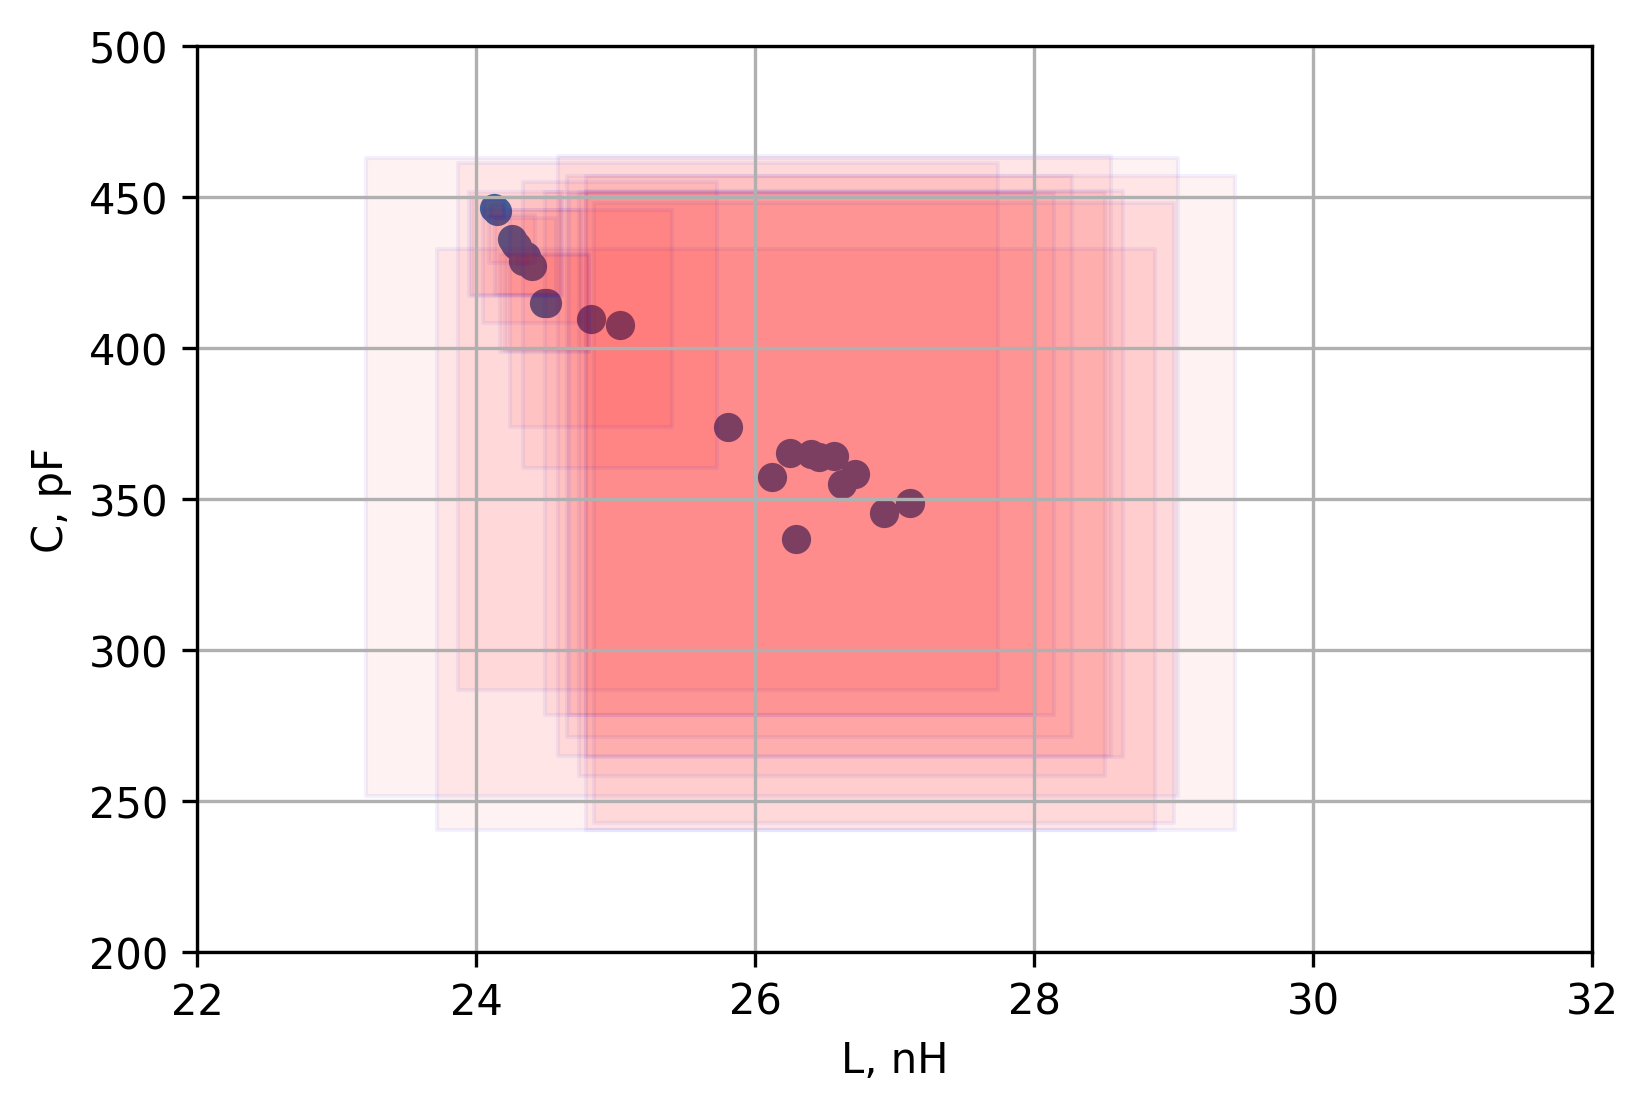

In [18]:
#draw L and C diagram

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

# Create figure and axes
fig,ax = plt.subplots(1)

x=[]
y=[]

errorboxes = []

for i in optimums_l:

  #print(optimums_l[i])
  Lmin, Lmax, Cmin, Cmax = optimums_l[i]
  x.append((Lmax+Lmin)/2)
  y.append((Cmax+Cmin)/2)
  xy=(Lmin,Cmin)
  w=Lmax-Lmin
  h=Cmax-Cmin
  rect = Rectangle(xy, w, h)
  errorboxes.append(rect)

ax.scatter(x,y)

plt.xlabel('L, nH')
plt.ylabel('C, pF')

pc = PatchCollection(errorboxes, facecolor='r', alpha=0.05, edgecolor='b')#,alpha=alpha)
ax.add_collection(pc)
ax.set_xlim((22, 32))
ax.set_ylim((200, 500))
ax.grid(visible=True, which='both', axis='both')
#fig.set_size_inches(2, 2)
fig.set_dpi(300)
fig.savefig(base_path + 'lc_ranges.png')
#plt.show()


In [22]:
# draw plasma impedance and mirror assembly impedance
import numpy as np
import plotly.graph_objects as go
from google.colab import drive
import csv
import plotly.express as px

infiles = [#'0.5Pa_50W_83.0MHz_SWR1.2_D_Ar',
            #'0.5Pa_150W_82.3MHz_SWR1.4_D_Ar',
            #'0.5Pa_300W_83.2MHz_SWR1.5_D_Ar',
            #'3Pa_50W_81.8MHz_SWR1.2_D_Ar',
            #'3Pa_150W_81.4MHz_SWR1.4_D_Ar',
            #'3Pa_300W_80.6MHz_SWR1.6_D_Ar',
            #'7Pa_50W_79.1MHz_SWR1.2_D_Ar',
            #'7Pa_150W_79.2MHz_SWR1.2_D_Ar',
            #'7Pa_300W_79.1MHz_SWR1.9_D_Ar',
            #'10Pa_50W_78.9MHz_SWR1.6_D_Ar',
            #'10Pa_150W_79.2MHz_SWR1.2_D_Ar',
            #'10Pa_300W_79.1MHz_SWR2_D_Ar',
            #'0.5Pa_50W_82.9MHz_SWR_2_C_Ar',
            #'0.5Pa_150W_83.2MHz_SWR2.5_C_Ar',
            #'3Pa_50W_78.5MHz_SWR2.3_C_Ar',
            #'3Pa_150W_80.3MHz_SWR2.7_C_Ar',
            #'7Pa_50W_78.3MHz_SWR2.2_C_Ar',
            #'7Pa_150W_78.2MHz_SWR2.4_C_Ar',
            #'10Pa_50W_78.2MHz_SWR2_C_Ar',
            #'10Pa_150W_77.8MHz_SWR2.5_C_Ar',
            '0.5Pa_50W_82.3MHz_SWR2.2_C_He',
            '0.5Pa_150W_82.4MHz_SWR3.0_C_He',
            '0.5Pa_250W_80.6MHz_SWR3.0_C_He',
            '3Pa_50W_79.9MHz_SWR2.7_C_He',
            '3Pa_150W_77.9MHz_SWR2.8_C_He',
            '3Pa_250W_78.3MHz_SWR3.0_C_He',
            '7Pa_50W_78.2MHz_SWR2.3_C_He',
            '7Pa_150W_78.0MHz_SWR2.5_C_He',
            '7Pa_250W_77.8MHz_SWR2.6_C_He',
            '10Pa_50W_78.2MHz_SWR2.4_C_He',
            '10Pa_150W_77.1MHz_SWR2.4_C_He',
            '10Pa_250W_77.1MHz_SWR2.6_C_He',
            '0.5Pa_50W_84.1MHz_SWR1.2_D_He',
            '0.5Pa_150W_83.9MHz_SWR1.35_D_He',
            '0.5Pa_300W_84.0MHz_SWR1.35_D_He',
            '3Pa_50W_81.0MHz_SWR1.3_D_He',
            '3Pa_150W_81.3MHz_SWR1.2_D_He',
            '3Pa_300W_81.5MHz_SWR1.25_D_He',
            '7Pa_50W_79.8MHz_SWR1.5_D_He',
            '7Pa_150W_80.2MHz_SWR1.25_D_He',
            '7Pa_300W_80.7MHz_SWR1.1_D_He',
            '10Pa_50W_79.3MHz_SWR1.6_D_He',
            '10Pa_150W_79.9MHz_SWR1.25_D_He',
            '10Pa_300W_80.3MHz_SWR1.1_D_He'
    ] 

base_path = '/content/drive/My Drive/to2rep/'

fig1 = go.Figure(go.Scattersmith(showlegend=True))

i=0
for s in infiles:
  fname = base_path + s + '_results.txt'
  data = np.genfromtxt(fname, dtype=float, delimiter=',', names=['zin_re', 'zin_im', 'zin_mas_re', 'zin_mas_im', 'zload_re', 'zload_im'])
  fig1.add_trace(go.Scattersmith(imag=data['zin_mas_im'], real=data['zin_mas_re'], mode='markers', marker_color='black', name='MAS ' + s))
  fig1.add_trace(go.Scattersmith(imag=data['zload_im']/50, real=data['zload_re']/50, mode='markers', marker_color=px.colors.qualitative.Dark24[i], name=s))
  i=i+1

fig1.update_layout(
    autosize=False,
    width=1000,
    height=1000,
    paper_bgcolor="LightSteelBlue",
)

fig1.update_traces(marker=dict(size=2,
                              line=dict(width=0)),
                  selector=dict(mode='markers'))
fig1.show()
fig1.write_image(base_path + 'impedance_ranges.png', scale=4)


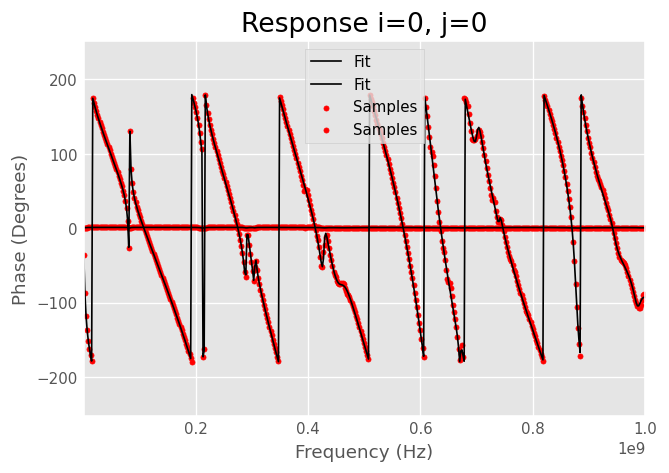

In [ ]:
import numpy as np  # for np.allclose() to check that S-params are similar
import skrf as rf
from google.colab import drive
circuit = rf.Network('/content/drive/My Drive/to2rep/su.s1p')

vf = rf.VectorFitting(circuit)
vf.vector_fit(n_poles_real=10, n_poles_cmplx=15)
vf.passivity_enforce()

vf.plot_s_mag()
vf.plot_s_deg()


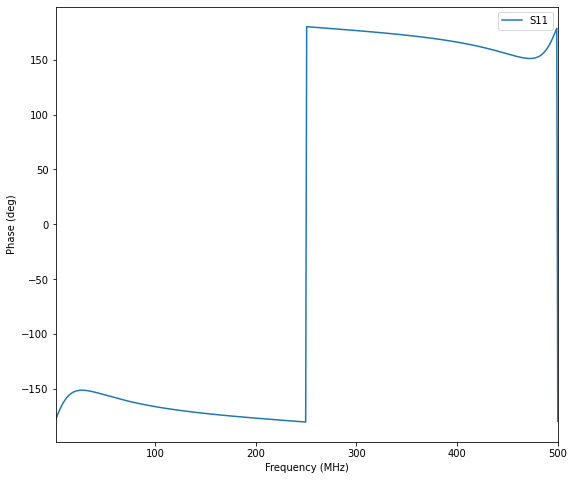

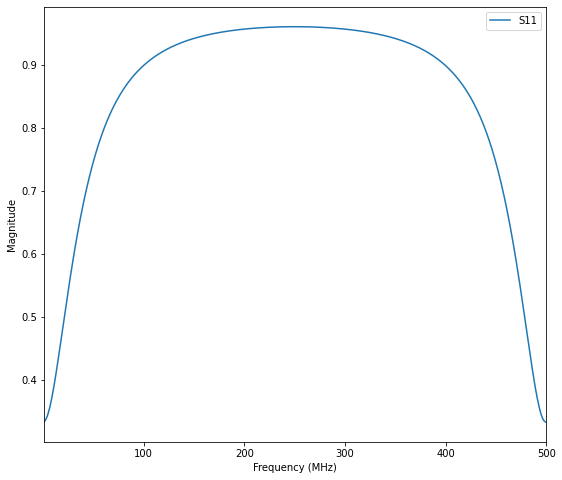

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skrf as rf
from skrf.media.definedAEpTandZ0 import DefinedAEpTandZ0

freq = rf.Frequency(1, 500, 501, 'MHz');


beta0 = freq.w/(rf.c*np.sqrt(1))
line0 = rf.media.DefinedGammaZ0(frequency=freq, Z0=50, gamma=0+beta0*1j)

line1 = DefinedAEpTandZ0(frequency=freq, A=0, f_A=80e6, ep_r=9, Z0=5)

tl1 = line1.line(100, 'mm', name='tl1')

r1 = line0.resistor(25, name='r1')

gnd = rf.Circuit.Ground(freq, name='gnd')

port1 = rf.Circuit.Port(freq, name='port1', z0=50)

cnx = [
  [(port1, 0), (tl1, 0)],
  [(tl1, 1), (r1, 0)],
  [(r1, 1), (gnd, 0)]
]

c = rf.Circuit(cnx)

fig1 = plt.figure(figsize=(9,8))
ax1 = fig1.add_axes()
c.network.plot_s_deg(ax=ax1)

fig2 = plt.figure(figsize=(9,8))
ax2 = fig2.add_axes()
c.network.plot_s_mag(ax=ax2)



In [ ]:
  print(optimums)

{'10Pa_300W_79.1MHz_SWR2_D_Ar': (23.562561523702826, 26.8887582117783, 313.2655792145699, 456.0898263029257)}


In [ ]:
import math

np.round(np.linspace(1, x.size-1, sz)).astype(int)

array([  1,   2,   3,   4,   5,   7,   8,   9,  10,  11,  12,  13,  14,
        16,  17,  18,  19,  20,  21,  22,  23,  24,  26,  27,  28,  29,
        30,  31,  32,  33,  35,  36,  37,  38,  39,  40,  41,  42,  44,
        45,  46,  47,  48,  49,  50,  51,  52,  54,  55,  56,  57,  58,
        59,  60,  61,  63,  64,  65,  66,  67,  68,  69,  70,  71,  73,
        74,  75,  76,  77,  78,  79,  80,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  92,  93,  94,  95,  96,  97,  98,  99, 101, 102,
       103, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 144, 145,
       146, 148, 149, 150, 151, 152, 153, 154, 155, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 167, 168, 169, 170, 171, 172, 173, 174,
       176, 177, 178, 179, 180])

In [ ]:
import pickle

a = {}

a['a'] = (1,2)
a['b'] = (3,4)

with open(base_path + 'saved_dictionary.pkl', 'wb') as f:
    pickle.dump(a, f)

with open(base_path + 'saved_dictionary.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

In [ ]:
  fig = go.Figure(go.Scattersmith(imag=np.imag(vswr_circle(swr0)), real=np.real(vswr_circle(swr0)), marker_color="green", showlegend=True, name='swr='+str(swr0)))

#  fig.show()
  fig.write_image(base_path + 'test.png')

  #np.savetxt(base_path + mode + '_re.txt', zin_mas_re, delimiter=',')
  #np.savetxt(base_path + mode + '_im.txt', zin_mas_im, delimiter=',')

  #cir.plot_graph(network_labels=True, network_fontsize=10,
  #               port_labels=True, port_fontsize=10,
  #              edge_labels=False, edge_fontsize=10)

  #ntw.plot_s_smith(draw_vswr=True)


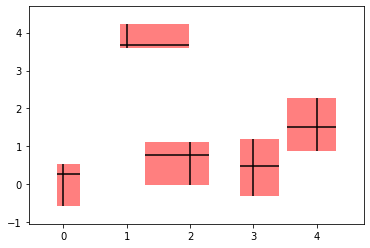

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

# Number of data points
n=5

# Dummy data
x=np.arange(0,n,1)
y=np.random.rand(n)*5.

# Dummy errors (above and below)
xerr=np.random.rand(2,n)
yerr=np.random.rand(2,n)

# Create figure and axes
fig,ax = plt.subplots(1)

# Plot data points
ax.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='None',ecolor='k')

# Function to plot error boxes
def makeErrorBoxes(xdata,ydata,xerror,yerror,fc='r',ec='None',alpha=0.5):

    # Create list for all the error patches
    errorboxes = []

    # Loop over data points; create box from errors at each point
    for xc,yc,xe,ye in zip(xdata,ydata,xerror.T,yerror.T):
        rect = Rectangle((xc-xe[0],yc-ye[0]),xe.sum(),ye.sum())
        errorboxes.append(rect)

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(errorboxes,facecolor=fc,alpha=alpha,edgecolor=ec)

    # Add collection to axes
    ax.add_collection(pc)

# Call function to create error boxes
makeErrorBoxes(x,y,xerr,yerr)

# Add some space around the data points on the axes
ax.margins(0.1)

plt.show()
